In [10]:
#!pip install yfinance

In [24]:
import requests
import bs4 as bs
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [12]:
#the following code webscrapes all tickers from the SP500
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

#list of tickers we want
tickers = []
#dictionary with sectors of stocks
d_sect = {}
d_name = {}
#scraping 
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text.replace('\n', '')
    sector = row.findAll('td')[3].text
    name = row.findAll('td')[1].text
    d_sect[ticker] = sector
    d_name[ticker] = name
    tickers.append(ticker)
#tickers = ['AAPL', 'MSFT', 'GOOGL']

In [13]:
#getting the yfinance multiindex dataframe of all the tickers using the .download method
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2022, 1, 1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1577854800, endDate = 1641013200
- BF.B: No data found for this date range, symbol may be delisted


In [15]:
df = data.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
#adding sector column
for stock in tickers:
  try:
    df.loc[df["Symbol"] == stock, "Sector"] = d_sect[stock]
    df.loc[df["Symbol"] == stock, "Company"] = d_name[stock]
  except:
    df.loc[df["Symbol"] == stock, "Sector"] = np.nan
    df.loc[df["Symbol"] == stock, "Company"] = np.nan
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Sector,Company
0,2020-01-02,A,84.517052,85.949997,86.349998,85.199997,85.900002,1410500.0,Health Care,Agilent Technologies
497,2020-01-03,A,83.160049,84.570000,85.330002,84.500000,84.669998,1118300.0,Health Care,Agilent Technologies
994,2020-01-06,A,83.405891,84.820000,84.820000,83.599998,84.000000,1993200.0,Health Care,Agilent Technologies
1491,2020-01-07,A,83.661545,85.080002,85.260002,83.940002,83.959999,1684700.0,Health Care,Agilent Technologies
1988,2020-01-08,A,84.487534,85.919998,86.470001,85.199997,85.959999,1847600.0,Health Care,Agilent Technologies


In [16]:
#removing columns we don't need
df.drop(columns=["Volume", "Low", "High", "Open", "Adj Close"], inplace = True)
df.head()

,Date,Symbol,Close,Sector,Company
0,2020-01-02,A,85.949997,Health Care,Agilent Technologies
497,2020-01-03,A,84.570000,Health Care,Agilent Technologies
994,2020-01-06,A,84.820000,Health Care,Agilent Technologies
1491,2020-01-07,A,85.080002,Health Care,Agilent Technologies
1988,2020-01-08,A,85.919998,Health Care,Agilent Technologies


In [17]:
#dataframe for SPY 
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2022, 1, 1)
data = yf.download('SPY', start=start, end=end)
spy = data.reset_index()
spy.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,311.117004,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,308.761200,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,309.939148,55653900
3,2020-01-07,323.019989,323.540009,322.239990,322.730011,309.067657,40496400
4,2020-01-08,322.940002,325.779999,322.670013,324.450012,310.714813,68296000


In [18]:
spy.drop(columns=["Volume", "Low", "High", "Open", "Adj Close"], inplace = True)
spy.head()

,Date,Close
0,2020-01-02,324.869995
1,2020-01-03,322.410004
2,2020-01-06,323.640015
3,2020-01-07,322.730011
4,2020-01-08,324.450012


In [19]:
#getting percentage change of stocks
pct = pd.DataFrame()
for stock in list(df['Symbol'].unique()):
  temp = df[df['Symbol'] == stock].copy()
  temp['Percent_Change'] = temp['Close'].pct_change()
  pct = pd.concat([pct, temp])

pct.head()

,Date,Symbol,Close,Sector,Company,Percent_Change
0,2020-01-02,A,85.949997,Health Care,Agilent Technologies,NaN
497,2020-01-03,A,84.570000,Health Care,Agilent Technologies,-0.016056
994,2020-01-06,A,84.820000,Health Care,Agilent Technologies,0.002956
1491,2020-01-07,A,85.080002,Health Care,Agilent Technologies,0.003065
1988,2020-01-08,A,85.919998,Health Care,Agilent Technologies,0.009873


In [20]:
#getting percentage change of SPY
spy['Percent_Change'] = spy['Close'].pct_change()
spy.head()

,Date,Close,Percent_Change
0,2020-01-02,324.869995,NaN
1,2020-01-03,322.410004,-0.007572
2,2020-01-06,323.640015,0.003815
3,2020-01-07,322.730011,-0.002812
4,2020-01-08,324.450012,0.005330


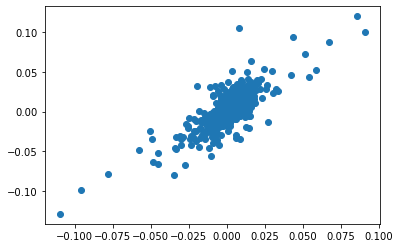

 
Correlation: 0.7978688368129204


In [25]:
#showing similarity between sp500 and Apple
col1 = spy['Percent_Change'].dropna().reset_index().drop(columns = ['index'])['Percent_Change']
col2 = pct[pct['Symbol'] == "AAPL"]['Percent_Change'].dropna().reset_index().drop(columns = ['index'])['Percent_Change']
plt.scatter(col1, col2)
plt.show()
correlation = col1.corr(col2)
print(" ")
print(f"Correlation: {correlation}")

In [26]:
corr_df = pd.DataFrame({'Symbol': tickers})
spy_pct_col = spy['Percent_Change'].dropna().reset_index().drop(columns = ['index'])['Percent_Change']
for s in tickers:
  stock_pct = pct[pct['Symbol'] == s]['Percent_Change'].dropna().reset_index().drop(columns = ['index'])['Percent_Change']
  try:
    corr_df.loc[corr_df["Symbol"] == s, "Sector"] = d_sect[s]
    corr_df.loc[corr_df["Symbol"] == s, "Company"] = d_name[s]
    corr_df.loc[corr_df["Symbol"] == s, "Correlation"] = spy_pct_col.corr(stock_pct)
  except:
    corr_df.loc[corr_df["Symbol"] == s, "Sector"] = np.nan
    corr_df.loc[corr_df["Symbol"] == s, "Company"] = np.nan
corr_df.head()

,Symbol,Sector,Company,Correlation
0,MMM,Industrials,3M,0.683879
1,AOS,Industrials,A. O. Smith,0.585356
2,ABT,Health Care,Abbott,0.665361
3,ABBV,Health Care,AbbVie,0.630391
4,ABMD,Health Care,Abiomed,0.445982


In [27]:
corr_df = corr_df.sort_values(by="Correlation", ascending = False)
corr_df.head()

,Symbol,Sector,Company,Correlation
36,AMP,Financials,Ameriprise Financial,0.862691
38,AME,Industrials,Ametek,0.854128
40,APH,Information Technology,Amphenol,0.850969
314,MSFT,Information Technology,Microsoft,0.845984
475,V,Information Technology,Visa Inc.,0.839206


In [28]:
#converting dataframes into pickle files for easy access
pct.to_pickle("data.pkl")

In [29]:
corr_df.to_pickle("corr_df.pkl")

In [30]:
spy.to_pickle("spy.pkl")